# <span style='color:#009999'> <span style='font-family:serif'> <font size="15"> **LLC4320 data access demonstration using `xarray`**
 
    
    
<font size="3"> This notebook demonstrates easy access to LLC4320 in `zarr` format, available on Johns Hopkins University's SciServer/Grendel domain.


<span style='color:#0066cc'><font size="5"> **The current grendel environment requires**:
```python
pip install --upgrade fsspec
pip install --upgrade xarray
pip install --upgrade dask
pip install --upgrade distributed
```
    
<font size="3"> Miguel A. Jimenez-Urias May '25


In [1]:
import fsspec
import xarray as xr

import dask
from dask import delayed, compute
from dask.distributed import Client

import matplotlib.pyplot as plt

import gc

In [2]:
print("fsspec version: ", fsspec.__version__)
print("xarray: ", xr.__version__)
print("dask version: ", dask.__version__)

fsspec version:  2025.3.2
xarray:  2024.7.0
dask version:  2024.8.0


In [3]:
client = Client(n_workers=4, threads_per_worker=2)  # Basic limited cpu example
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45337,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://127.0.0.1:41561,Total threads: 2
Dashboard: http://127.0.0.1:40331/status,Memory: 59.60 GiB
Nanny: tcp://127.0.0.1:35225,


<span style='color:#0066cc'><font size="5"> **Json Kerchunk references**

<font size="3"> Each LLC4320 variable has an associated json Kerchunk metadata reference file that enables to create a self-consistent, `xarray` dataset for that variable. This is necessary because in `ceph` (the underlying storage platform), data is spread across multiple locations, rather than in a single consolidated `zarr` store.

<font size="3"> Using these metadata reference files allows `xarray` dataset to be built quickly for each variable of interest. 


In [4]:
ls -l "/home/idies/workspace/poseidon_ceph/LLC4320/Kerchunks"

total 11779764
-rw-r--r--. 1 idies idies 579825142 May  2 12:48 LLC4320_Eta.json
-rw-r--r--. 1 idies idies 608778471 May  2 12:48 LLC4320_KPPhbl.json
-rw-r--r--. 1 idies idies 608778461 May  2 12:48 LLC4320_PhiBot.json
-rw-r--r--. 1 idies idies 546047505 May  2 12:48 LLC4320_SALT.json
-rw-r--r--. 1 idies idies 608778467 May  2 12:48 LLC4320_SIarea.json
-rw-r--r--. 1 idies idies 608778446 May  2 12:48 LLC4320_SIheff.json
-rw-r--r--. 1 idies idies 617814306 May  2 12:48 LLC4320_SIhsalt.json
-rw-r--r--. 1 idies idies 618429546 May  2 12:48 LLC4320_SIhsnow.json
-rw-r--r--. 1 idies idies 608778540 May  2 12:48 LLC4320_SIuice.json
-rw-r--r--. 1 idies idies 608778543 May  2 12:48 LLC4320_SIvice.json
-rw-r--r--. 1 idies idies 259320298 May  2 12:48 LLC4320_Surface.json
-rw-r--r--. 1 idies idies 560524170 May  2 12:48 LLC4320_THETA.json
-rw-r--r--. 1 idies idies 502617667 May  2 12:48 LLC4320_U.json
-rw-r--r--. 1 idies idies 502617672 May  2 12:48 LLC4320_V.json
-rw-r--r--. 1 idies idies 502617

In [5]:
ceph_path = "/home/idies/workspace/poseidon_ceph/LLC4320/"
Ker_path = ceph_path + "Kerchunks/"

# Individual 4D variables:
Salt_json= Ker_path + "LLC4320_SALT.json"
Theta_json = Ker_path + "LLC4320_THETA.json"
U_json =  Ker_path + "LLC4320_U.json"
V_json =  Ker_path+ "LLC4320_V.json"
W_json =   Ker_path + "LLC4320_W.json"

# Individual 3D (surface) variables:
Eta_json = Ker_path + "LLC4320_Eta.json"
KPPhbl_json = Ker_path + "LLC4320_KPPhbl.json"
PhiBot_json =  Ker_path + "LLC4320_PhiBot.json"
SIarea_json =  Ker_path + "LLC4320_SIarea.json"
SIheff_json =  Ker_path + "LLC4320_SIheff.json"
SIhsalt_json =  Ker_path + "LLC4320_SIhsalt.json"
SIhsnow_json =  Ker_path + "LLC4320_SIhsnow.json"
SIuice_json =  Ker_path + "LLC4320_SIuice.json"
SIvice_json =  Ker_path + "LLC4320_SIvice.json"
oceFWflx_json =  Ker_path + "LLC4320_oceFWflx.json"
oceQnet_json =  Ker_path + "LLC4320_oceQnet.json"
oceQsw_json =  Ker_path + "LLC4320_oceQsw.json"
oceSflux_json =  Ker_path + "LLC4320_oceSflux.json"
oceTAUX_json =  Ker_path + "LLC4320_oceTAUX.json"
oceTAUY_json =  Ker_path + "LLC4320_oceTAUY.json"

<span style='color:#0066cc'><font size="5"> **Open the zarr stores**


### Identify all variables you need in your dataset by including the json path of its Kerchunk references 

```python
json_paths=[Kerchunk_json1, Kerchunk_json2,...]
```

<font size="3"> You select only the variables of interest as follows:

In [6]:
# Here, add the json files of the variables you want to include in your dataset
json_paths = [Salt_json, Theta_json, U_json, V_json, W_json, Eta_json, KPPhbl_json, 
              PhiBot_json,  SIarea_json, SIheff_json, SIhsalt_json, SIhsnow_json, 
              SIuice_json, SIvice_json, oceFWflx_json, oceQnet_json, oceQsw_json,
              oceSflux_json, oceTAUX_json, oceTAUY_json,
             ]

# ====================================================================================
# Preselect the variables you are interested! This provides a boost in performance.
# For example, the following pre-selects a few variable that make up the bulk of LLC4320
# ====================================================================================

json_paths = json_paths[:6]
json_paths

['/home/idies/workspace/poseidon_ceph/LLC4320/Kerchunks/LLC4320_SALT.json',
 '/home/idies/workspace/poseidon_ceph/LLC4320/Kerchunks/LLC4320_THETA.json',
 '/home/idies/workspace/poseidon_ceph/LLC4320/Kerchunks/LLC4320_U.json',
 '/home/idies/workspace/poseidon_ceph/LLC4320/Kerchunks/LLC4320_V.json',
 '/home/idies/workspace/poseidon_ceph/LLC4320/Kerchunks/LLC4320_W.json',
 '/home/idies/workspace/poseidon_ceph/LLC4320/Kerchunks/LLC4320_Eta.json']


<span style='color:#0066cc'><font size="5"> **LLC4320 grid and masks**


In [7]:
grid_path = ceph_path
ds_grid = xr.open_zarr(grid_path)
ds_grid = ds_grid.set_coords([var for var in ds_grid.data_vars])
ds_grid

<xarray.Dataset> Size: 346GB
Dimensions:  (face: 13, j: 4320, i: 4320, k: 90, k_p1: 91, j_g: 4320,
              i_g: 4320, k_l: 90, k_u: 90)
Coordinates: (12/43)
    CS       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    Depth    (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    PHrefC   (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
    PHrefF   (k_p1) float32 364B dask.array<chunksize=(91,), meta=np.ndarray>
    SN       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    XC       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    ...       ...
    mask_w   (k, face, j, i_g) bool 22GB dask.array<chunksize=(90, 1, 720, 720), meta=np.ndarray>
    rA       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAs      (face, j_g, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAw      (face, j, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rhoRef   (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
Data variables:
    *empty*

<span style='color:#0066cc'><font size="5"> **Create xarray datasets for each individual variable**

<font size="3"> The xarray dataset creation may take $\sim 10\times N $ seconds, with $N$ the number of variables selected (json files).  
    
<font size="3"> **NOTE**: There is no significant performance gain when using `dask` for parallel read/creation of the mapper object. The code runs sequentially (unfortunately). But using `dask` provides a clean way to create the xarray dataset in a few lines, avoiding repeated code.

In [8]:
def open_mapper(json_file):
    fs = fsspec.filesystem("reference", fo=json_file)
    mapper = fs.get_mapper("")
    return mapper

In [9]:
%%time
# Distribute JSON paths to workers first
scattered_paths = client.scatter(json_paths, broadcast=False)
# Then submit open_mapper to each
futures = [client.submit(open_mapper, path) for path in scattered_paths]

# Optionally wait for all to complete
mappers = client.gather(futures)  # This doesn't move data, just ensures completion

CPU times: user 54.1 s, sys: 4.19 s, total: 58.3 s
Wall time: 1min 14s


<span style='color:#0066cc'><font size="5"> **Concatenate into a single xarray dataset**

In [10]:
%%time
ds = xr.merge([xr.open_zarr(mapper, consolidated=False) for mapper in mappers]+[ds_grid])
ds

CPU times: user 23.4 s, sys: 416 ms, total: 23.8 s
Wall time: 23.7 s


<xarray.Dataset> Size: 5PB
Dimensions:  (time: 10311, k: 90, face: 13, j: 4320, i: 4320, i_g: 4320,
              j_g: 4320, k_l: 90, k_p1: 91, k_u: 90)
Coordinates: (12/44)
  * face     (face) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 35kB 0 1 2 3 4 5 6 ... 4313 4314 4315 4316 4317 4318 4319
  * k        (k) int64 720B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 82kB 2011-09-13 ... 2012-11-15T14:00:00
  * i_g      (i_g) int64 35kB 0 1 2 3 4 5 6 ... 4314 4315 4316 4317 4318 4319
    ...       ...
    mask_w   (k, face, j, i_g) bool 22GB dask.array<chunksize=(90, 1, 720, 720), meta=np.ndarray>
    rA       (face, j, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAs      (face, j_g, i) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAw      (face, j, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 970MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    rhoRef   (k) float32 360B dask.array<chunksize=(90,), meta=np.ndarray>
Data variables:
    Salt     (time, k, face, j, i) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    Theta    (time, k, face, j, i) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    U        (time, k, face, j, i_g) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    V        (time, k, face, j_g, i) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    W        (time, k_l, face, j, i) float32 901TB dask.array<chunksize=(1, 90, 1, 720, 720), meta=np.ndarray>
    Eta      (time, face, j, i) float32 10TB dask.array<chunksize=(1, 1, 720, 720), meta=np.ndarray>

In [11]:
print("Size of dataset (uncompressed) : ", ds.nbytes/1e15, "Petabytes")

Size of dataset (uncompressed) :  4.513167569890972 Petabytes


<span style='color:#0066cc'><font size="5">**Some plotting examples**

<font size="3">The following approach of closing the client before plotting is much faster.

In [12]:
# force cleanup
_ = client.run(gc.collect)  # also on workers

In [13]:
client.close()

CPU times: user 5.11 s, sys: 468 ms, total: 5.58 s
Wall time: 5.36 s


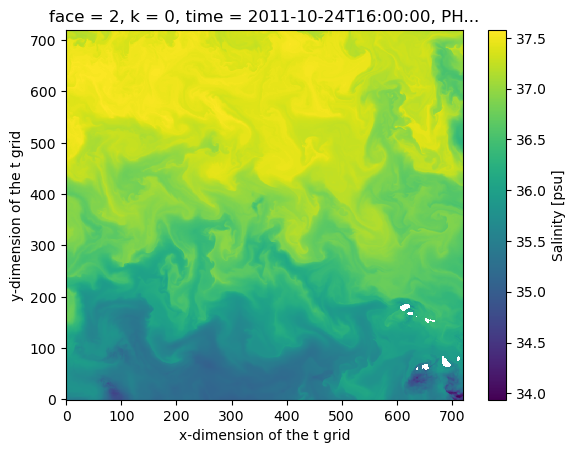

In [14]:
%%time
ds['Salt'].isel(time=1000, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot();

CPU times: user 5.19 s, sys: 461 ms, total: 5.65 s
Wall time: 5.43 s


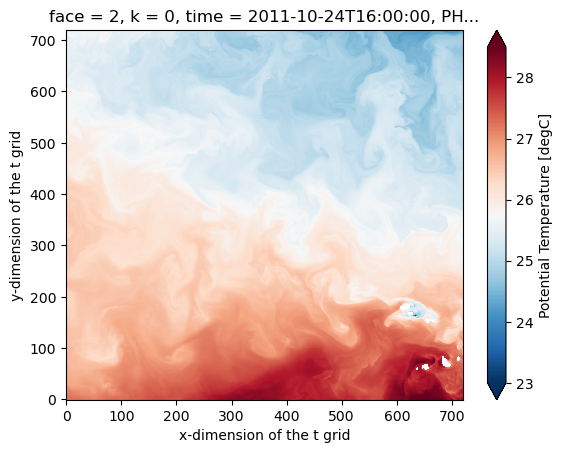

In [15]:
%%time
ds['Theta'].isel(time=1000, k=0, face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='RdBu_r', vmin=23, vmax=28.5);

CPU times: user 5.16 s, sys: 494 ms, total: 5.66 s
Wall time: 5.44 s


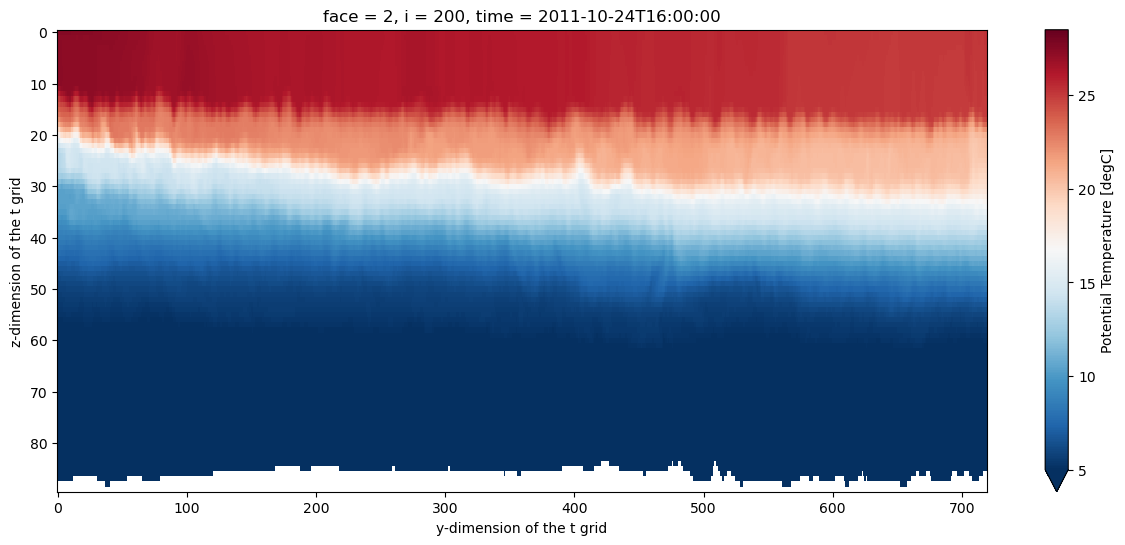

In [16]:
%%time
fig= plt.figure(figsize=(15, 6), frameon=True, facecolor='w')
ds['Theta'].isel(time=1000, face=2, i=200, j=slice(0, 720)).plot(cmap='RdBu_r', yincrease=False, vmin=5, vmax=28.5);

CPU times: user 5.18 s, sys: 509 ms, total: 5.69 s
Wall time: 5.48 s


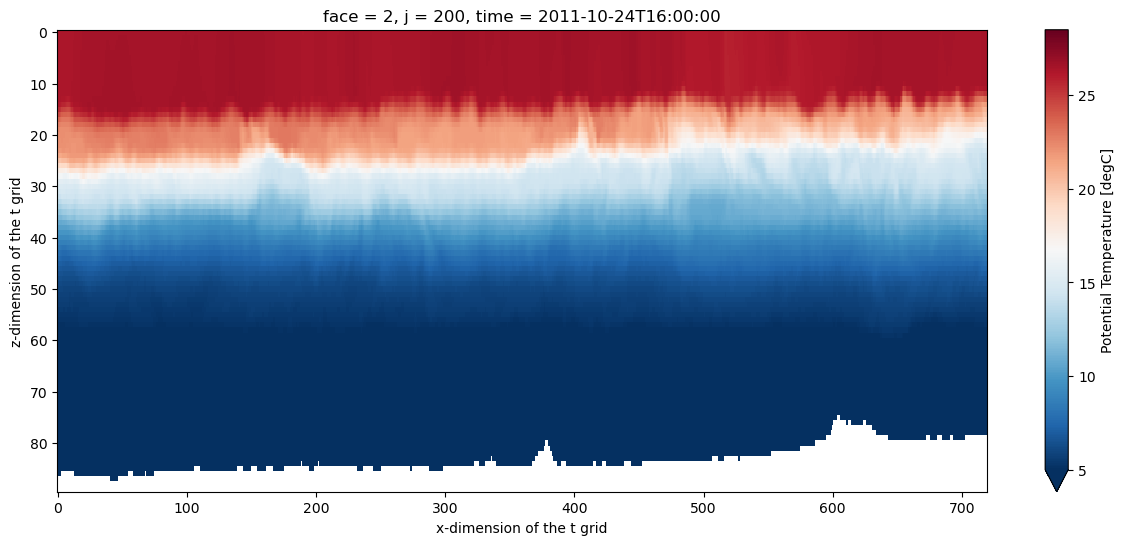

In [17]:
%%time
fig= plt.figure(figsize=(15, 6), frameon=True, facecolor='w')
ds['Theta'].isel(time=1000, face=2, i=slice(0, 720), j=200).plot(cmap='RdBu_r', yincrease=False, vmin=5, vmax=28.5);

CPU times: user 4.57 s, sys: 350 ms, total: 4.92 s
Wall time: 4.92 s


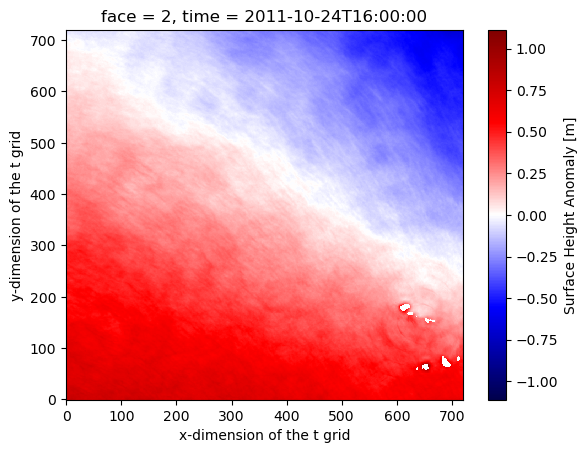

In [18]:
%%time
ds['Eta'].isel(time=1000,face=2, i=slice(0, 720), j=slice(0, 720)).plot(cmap='seismic');